# **Final Project**

##**Problem stament :**     

The widespread dissemination of fake news and propaganda presents serious societal risks, including the erosion of public trust, political polarization, manipulation of elections, and the spread of harmful misinformation during crises such as pandemics or conflicts. From an NLP perspective, detecting fake news is fraught with challenges. Linguistically, fake news often mimics the tone and structure of legitimate journalism, making it difficult to distinguish using surface-level features. The absence of reliable and up-to-date labeled datasets, especially across multiple languages and regions, hampers the effectiveness of supervised learning models. Additionally, the dynamic and adversarial nature of misinformation means that malicious actors constantly evolve their language and strategies to bypass detection systems. Cultural context, sarcasm, satire, and implicit bias further complicate automated analysis. Moreover, NLP models risk amplifying biases present in training data, leading to unfair classifications and potential censorship of legitimate content. These challenges underscore the need for cautious, context-aware approaches, as the failure to address them can inadvertently contribute to misinformation, rather than mitigate it.



Use datasets in link : https://drive.google.com/drive/folders/1mrX3vPKhEzxG96OCPpCeh9F8m_QKCM4z?usp=sharing
to complete requirement.

## **About dataset:**

* **True Articles**:

  * **File**: `MisinfoSuperset_TRUE.csv`
  * **Sources**:

    * Reputable media outlets like **Reuters**, **The New York Times**, **The Washington Post**, etc.

* **Fake/Misinformation/Propaganda Articles**:

  * **File**: `MisinfoSuperset_FAKE.csv`
  * **Sources**:

    * **American right-wing extremist websites** (e.g., Redflag Newsdesk, Breitbart, Truth Broadcast Network)
    * **Public dataset** from:

      * Ahmed, H., Traore, I., & Saad, S. (2017): "Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques" *(Springer LNCS 10618)*



## **Requirement**

A team consisting of three members must complete a project that involves applying the methods learned from the beginning of the course up to the present. The team is expected to follow and document the entire machine learning workflow, which includes the following steps:

1. **Data Preprocessing**: Clean and prepare the dataset,etc.

2. **Exploratory Data Analysis (EDA)**: Explore and visualize the data.

3. **Model Building**: Select and build one or more machine learning models suitable for the problem at hand.

4. **Hyperparameter set up**: Set and adjust the model's hyperparameters using appropriate methods to improve performance.

5. **Model Training**: Train the model(s) on the training dataset.

6. **Performance Evaluation**: Evaluate the trained model(s) using appropriate metrics (e.g., accuracy, precision, recall, F1-score, confusion matrix, etc.) and validate their performance on unseen data.

7. **Conclusion**: Summarize the results, discuss the model's strengths and weaknesses, and suggest possible improvements or future work.





In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
nltk.download('stopwords')
from nltk.corpus import stopwords
# -----------------------------------------
# 1. Load dữ liệu
# -----------------------------------------
true_df = pd.read_csv("/content/drive/MyDrive/DataSet_Misinfo_TRUE.csv")
fake_df = pd.read_csv("/content/drive/MyDrive/DataSet_Misinfo_FAKE.csv")

true_df['label'] = 0
fake_df['label'] = 1

df = pd.concat([true_df, fake_df], ignore_index=True).dropna()
df = df.sample(frac=1).reset_index(drop=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df.head()

,Unnamed: 0,text,label
0,34303,« on: Today at 01:06:08 AM » New Lunar Craters...,1
1,22685,21st Century Wire says If you ve been followin...,1
2,9178,One of the big players in trying to get to the...,1
3,13803,It was actually refreshing to see the cops fig...,1
4,43714,Political establishment prosecutes PEGIDA lead...,1


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df.head()

,text,label
0,« on: Today at 01:06:08 AM » New Lunar Craters...,1
1,21st Century Wire says If you ve been followin...,1
2,One of the big players in trying to get to the...,1
3,It was actually refreshing to see the cops fig...,1
4,Political establishment prosecutes PEGIDA lead...,1


In [6]:
df.duplicated().sum()

np.int64(9984)

In [7]:
df.isnull().sum()

,0
text,0
label,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78588 entries, 0 to 78587
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78588 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df['text'] = df['text'].astype(str) + ' ' + df['text'].astype(str)

# Function to clean text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub('\[.*?\]', '', text) # Remove square brackets
    text = re.sub("\\W"," ",text) # Remove non-word characters
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub('<.*?>+', '', text) # Remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    text = re.sub('\n', '', text) # Remove newlines
    text = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    return text

df['text'] = df['text'].apply(clean_text)

# Remove stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Optional: Remove short words (e.g., words with length less than 3)
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

# Display some processed text
print(df['text'].head())

0    today new lunar craters mystery space news htt...
1    century wire says following protest federal st...
2    one big players trying get truth bias presiden...
3    actually refreshing see cops fighting back unr...
4    political establishment prosecutes pegida lead...
Name: text, dtype: object


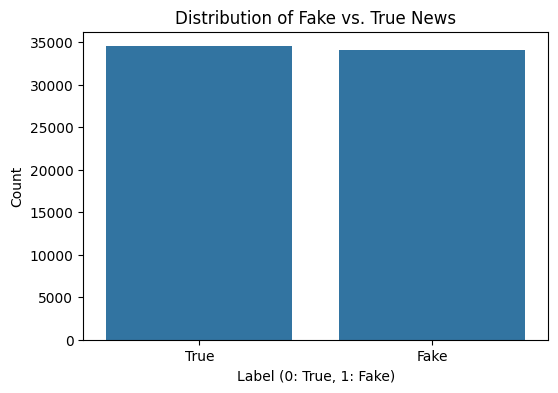

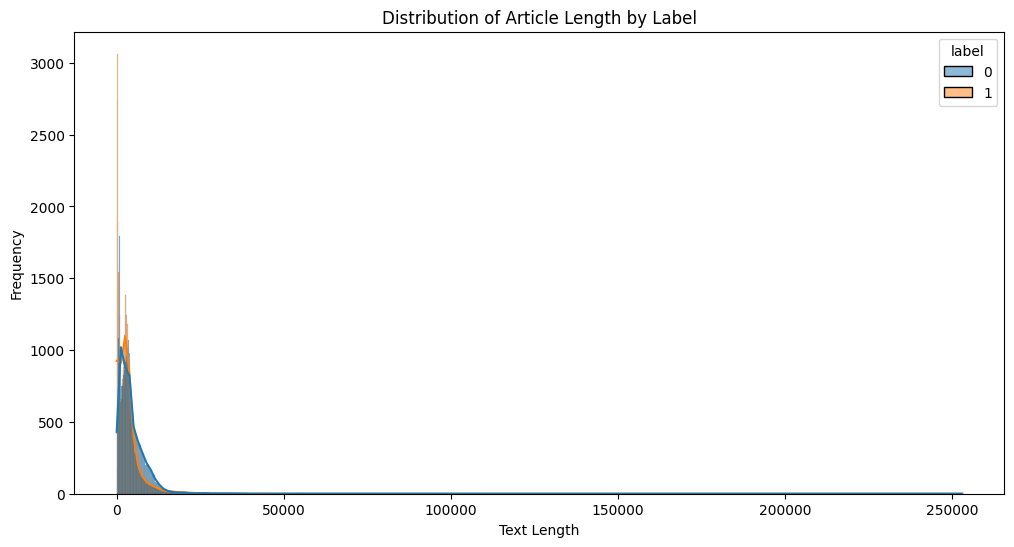

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Fake vs. True News')
plt.xlabel('Label (0: True, 1: Fake)')
plt.ylabel('Count')
plt.xticks([0, 1], ['True', 'Fake'])
plt.show()

# Analyze the length of the articles
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='label', kde=True)
plt.title('Distribution of Article Length by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()




Most Common Words in True News:
said: 331501
trump: 191764
would: 112062
president: 94155
one: 78662
people: 76075
new: 75692
state: 70246
also: 65830
states: 56811
could: 53400
government: 53002
clinton: 52628
house: 51970
two: 50980
year: 50326
united: 49569
last: 48446
republican: 48010
like: 46464

Most Common Words in Fake News:
trump: 178404
people: 77785
said: 74629
one: 71711
would: 67312
clinton: 67176
president: 59635
like: 50026
hillary: 46302
also: 44024
new: 42860
donald: 41772
even: 41483
obama: 40802
time: 40697
state: 37897
news: 31899
many: 31726
could: 31282
american: 31271


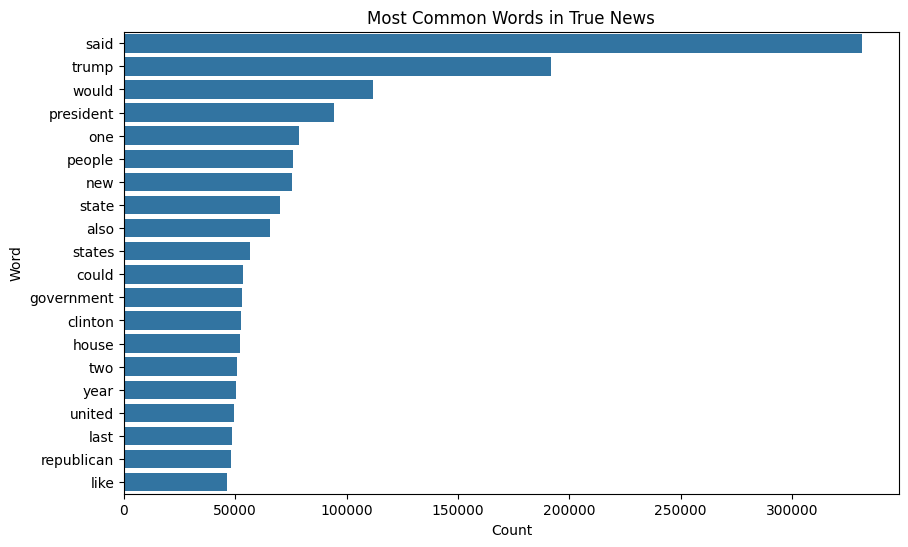

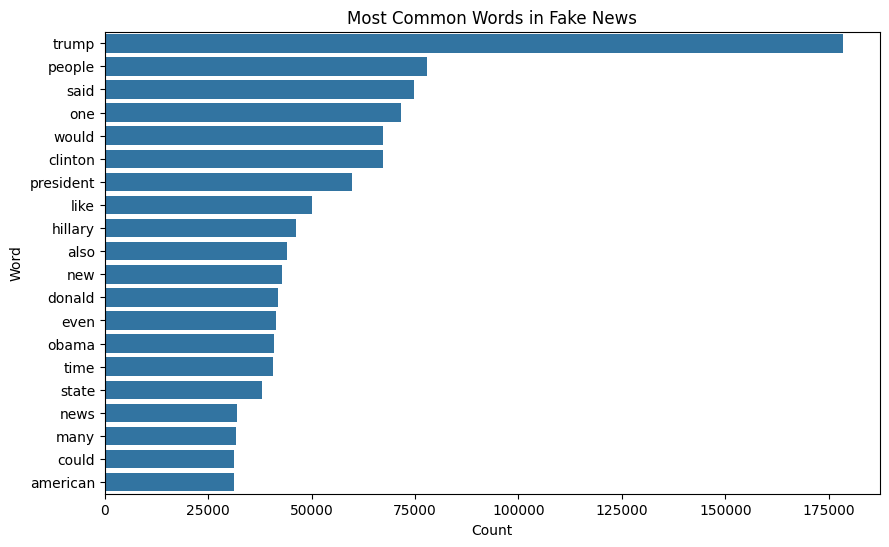


DataFrame Info after adding text_length and word_count:
<class 'pandas.core.frame.DataFrame'>
Index: 68604 entries, 0 to 78587
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         68604 non-null  object
 1   label        68604 non-null  int64 
 2   text_length  68604 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ MB


In [13]:
from collections import Counter

# Function to get most common words
def get_most_common_words(text_list, n=10):
    words = [word for text in text_list for word in text.split()]
    word_counts = Counter(words)
    return word_counts.most_common(n)

true_words = get_most_common_words(df[df['label'] == 0]['text'].tolist(), 20)
fake_words = get_most_common_words(df[df['label'] == 1]['text'].tolist(), 20)

print("\nMost Common Words in True News:")
for word, count in true_words:
    print(f"{word}: {count}")

print("\nMost Common Words in Fake News:")
for word, count in fake_words:
    print(f"{word}: {count}")

# Create bar plots for most common words
true_words_df = pd.DataFrame(true_words, columns=['word', 'count'])
fake_words_df = pd.DataFrame(fake_words, columns=['word', 'count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=true_words_df)
plt.title('Most Common Words in True News')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=fake_words_df)
plt.title('Most Common Words in Fake News')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()
print("\nDataFrame Info after adding text_length and word_count:")
df.info()

In [4]:
df = pd.read_csv('/content/drive/MyDrive/cleaned')

In [5]:
df.isnull().sum()

,0
text,7
label,0
text_length,0


In [6]:
df.head()

,text,label,text_length
0,link imo happening guys jumping conclusions co...,1,2717
1,house passed budget today slim margin democrat...,1,3203
2,youtube video posted january cloudgate studio ...,0,2549
3,marseille france sang danced chanted even reas...,0,8149
4,sunday nbc meet press discussing president don...,0,1235


In [5]:
df.dropna(inplace=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [6]:

# Initialize TfidfVectorizer
# You can experiment with parameters like max_features, ngram_range, stop_words etc.
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit the vectorizer on the training data and transform both train and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nShape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)



Shape of X_train_tfidf: (54877, 5000)
Shape of X_test_tfidf: (13720, 5000)


In [9]:
print("\nFirst 5 rows of X_train_tfidf (as dense array):\n", X_train_tfidf[:5].toarray())
print("\nType of X_train_tfidf:", type(X_train_tfidf))
print("Number of non-zero elements:", X_train_tfidf.nnz)
print("Sparsity ratio:", 1 - (X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])))


First 5 rows of X_train_tfidf (as dense array):
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.04036097 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Type of X_train_tfidf: <class 'scipy.sparse._csr.csr_matrix'>
Number of non-zero elements: 7976372
Sparsity ratio: 0.9709299998177743


In [7]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler(with_mean=False)
X_train_tfidf = scale.fit_transform(X_train_tfidf)
X_test_tfidf = scale.transform(X_test_tfidf)


Training LinearSVC model...
Training complete.

Evaluating LinearSVC model...

Classification Report for LinearSVC:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7045
           1       0.92      0.92      0.92      6675

    accuracy                           0.92     13720
   macro avg       0.92      0.92      0.92     13720
weighted avg       0.92      0.92      0.92     13720


Confusion Matrix for LinearSVC:
[[6502  543]
 [ 551 6124]]


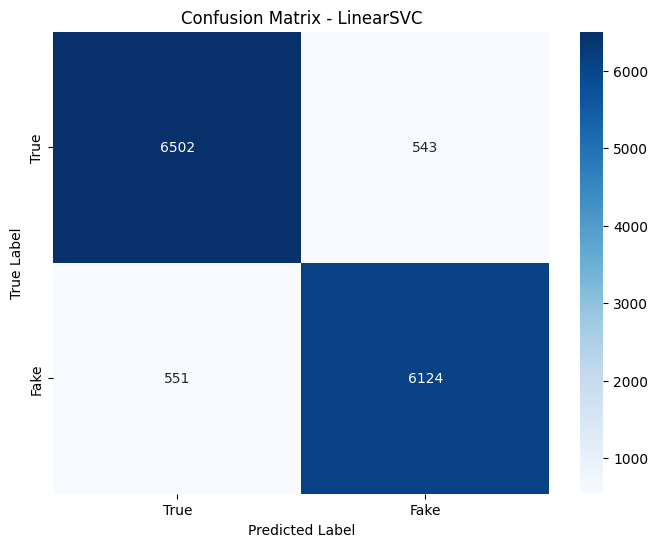

LinearSVC model evaluation complete.

Best parameters found by GridSearchCV:
{'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l1'}

Classification Report for Tuned LinearSVC:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7045
           1       0.93      0.92      0.93      6675

    accuracy                           0.93     13720
   macro avg       0.93      0.93      0.93     13720
weighted avg       0.93      0.93      0.93     13720



In [11]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

lsvm_model = LinearSVC(random_state=42, dual=False)
print("\nTraining LinearSVC model...")
lsvm_model.fit(X_train_tfidf, y_train)
print("Training complete.")
print("\nEvaluating LinearSVC model...")
# Predict on the test set
y_pred_lsvm = lsvm_model.predict(X_test_tfidf)

# Evaluate the model
print("\nClassification Report for LinearSVC:")
print(classification_report(y_test, y_pred_lsvm))

# Confusion Matrix
conf_matrix_lsvm = confusion_matrix(y_test, y_pred_lsvm)
print("\nConfusion Matrix for LinearSVC:")
print(conf_matrix_lsvm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lsvm, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.title('Confusion Matrix - LinearSVC')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("LinearSVC model evaluation complete.")
param_grid = {'C': [0.1, 1, 10],
              'penalty': ['l1','l2'],
              'loss': ['squared_hinge'],
              } # C is the regularization parameter

grid_search = GridSearchCV(LinearSVC(random_state=42, dual=False), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

best_lsvm_model = grid_search.best_estimator_
y_pred_best_lsvm = best_lsvm_model.predict(X_test_tfidf)
print("\nClassification Report for Tuned LinearSVC:")
print(classification_report(y_test, y_pred_best_lsvm))


In [11]:
from sklearn.svm import LinearSVC
lsvm_model = LinearSVC(random_state=42, dual=False,C=0.1, loss='squared_hinge', penalty='l1')
print("\nTraining LinearSVC model...")
lsvm_model.fit(X_train_tfidf, y_train)
print("Training complete.")
print("\nEvaluating LinearSVC model...")
# Predict on the test set
y_pred_lsvm = lsvm_model.predict(X_test_tfidf)

# Evaluate the model
print("\nClassification Report for LinearSVC:")
print(classification_report(y_test, y_pred_lsvm))

# Confusion Matrix
conf_matrix_lsvm = confusion_matrix(y_test, y_pred_lsvm)
print("\nConfusion Matrix for LinearSVC:")
print(conf_matrix_lsvm)
print("Training complete.")


Training LinearSVC model...
Training complete.

Evaluating LinearSVC model...

Classification Report for LinearSVC:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7045
           1       0.93      0.92      0.93      6675

    accuracy                           0.93     13720
   macro avg       0.93      0.93      0.93     13720
weighted avg       0.93      0.93      0.93     13720


Confusion Matrix for LinearSVC:
[[6565  480]
 [ 503 6172]]
Training complete.


In [10]:
from sklearn.preprocessing import StandardScaler
# Re-initialize TfidfVectorizer with fewer features
tfidf_vectorizer_smaller = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))

# Fit and transform data
X_train_tfidf_smaller = tfidf_vectorizer_smaller.fit_transform(X_train)
X_test_tfidf_smaller = tfidf_vectorizer_smaller.transform(X_test)

# Scale the smaller feature set
scale_smaller = StandardScaler(with_mean=False)
X_train_tfidf_smaller_scaled = scale_smaller.fit_transform(X_train_tfidf_smaller)
X_test_tfidf_smaller_scaled = scale_smaller.transform(X_test_tfidf_smaller)

svm_model_smaller_features = SVC(kernel='rbf', random_state=42)
print("\nTraining SVC model with fewer features...")
svm_model_smaller_features.fit(X_train_tfidf_smaller_scaled, y_train)
print("Training complete.")
y_pred_svm_smaller_features = svm_model_smaller_features.predict(X_test_tfidf_smaller_scaled)
print(classification_report(y_test, y_pred_svm_smaller_features))


Training SVC model with fewer features...
Training complete.
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7045
           1       0.93      0.94      0.94      6675

    accuracy                           0.94     13720
   macro avg       0.94      0.94      0.94     13720
weighted avg       0.94      0.94      0.94     13720




Training Logistic Regression model...
Training complete.

Evaluating Logistic Regression model...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      6913
           1       0.94      0.93      0.93      6808

    accuracy                           0.93     13721
   macro avg       0.93      0.93      0.93     13721
weighted avg       0.93      0.93      0.93     13721


Confusion Matrix for Logistic Regression:
[[6475  438]
 [ 454 6354]]


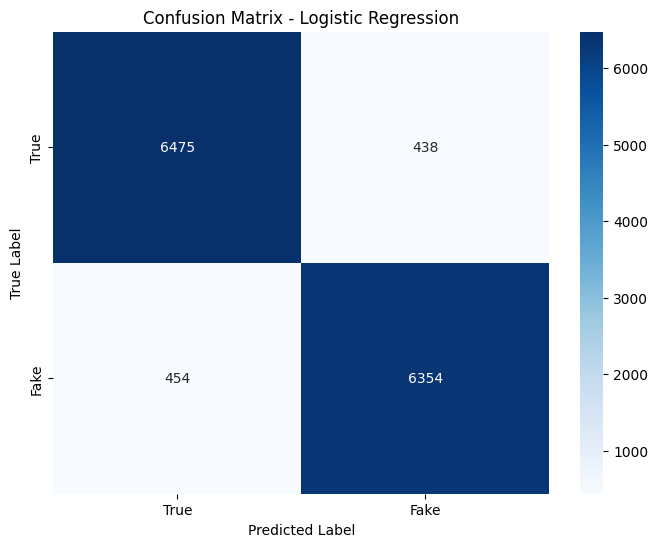


Logistic Regression Performance Metrics:
Accuracy: 0.9350
Precision (Fake News): 0.9355
Recall (Fake News): 0.9333
F1-score (Fake News): 0.9344
Logistic Regression model evaluation complete.


In [ ]:
# 3. Model Building (Logistic Regression)
# Initialize the Logistic Regression model
# C is the inverse of regularization strength; smaller values specify stronger regularization.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
log_reg_model = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' is a good choice for relatively small datasets and L2 regularization

# 4. Model Training
print("\nTraining Logistic Regression model...")
log_reg_model.fit(X_train_tfidf, y_train)
print("Training complete.")

# 5. Performance Evaluation
print("\nEvaluating Logistic Regression model...")
# Predict on the test set
y_pred_log_reg = log_reg_model.predict(X_test_tfidf)

# Evaluate the model
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))

# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("\nConfusion Matrix for Logistic Regression:")
print(conf_matrix_log_reg)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Extract specific metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, pos_label=1)
recall_log_reg = recall_score(y_test, y_pred_log_reg, pos_label=1)
f1_log_reg = f1_score(y_test, y_pred_log_reg, pos_label=1)

print("\nLogistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision (Fake News): {precision_log_reg:.4f}")
print(f"Recall (Fake News): {recall_log_reg:.4f}")
print(f"F1-score (Fake News): {f1_log_reg:.4f}")

print("Logistic Regression model evaluation complete.")


Starting GridSearchCV for Logistic Regression...
GridSearchCV complete.

Best parameters found by GridSearchCV for Logistic Regression:
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Best cross-validation F1 score: 0.9202

Evaluating the best Logistic Regression model on the test set...

Classification Report for Tuned Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7045
           1       0.93      0.92      0.93      6675

    accuracy                           0.93     13720
   macro avg       0.93      0.93      0.93     13720
weighted avg       0.93      0.93      0.93     13720


Confusion Matrix for Tuned Logistic Regression:
[[6611  434]
 [ 541 6134]]


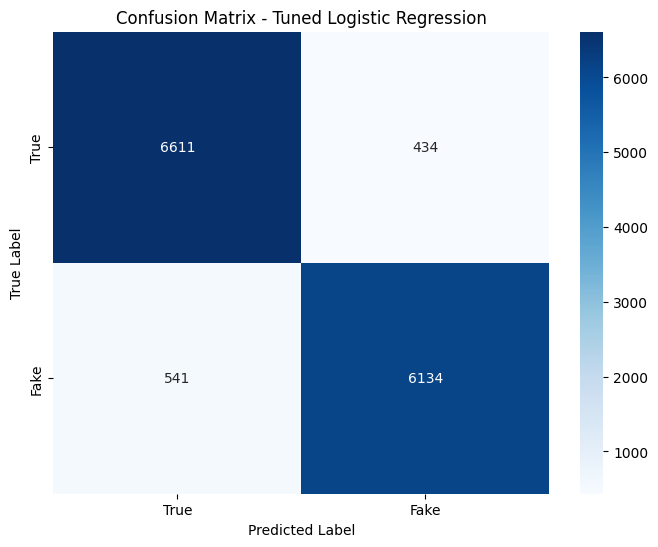


Tuned Logistic Regression Performance Metrics on Test Set:
Accuracy: 0.9289
Precision (Fake News): 0.9339
Recall (Fake News): 0.9190
F1-score (Fake News): 0.9264


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'], # L1 penalty can be used with 'liblinear' and 'saga'
    'solver': ['liblinear'] # Choose a solver compatible with the chosen penalty
}

grid_search_log_reg = GridSearchCV(LogisticRegression(random_state=42), param_grid_log_reg, cv=3, scoring='f1', n_jobs=-1)

print("\nStarting GridSearchCV for Logistic Regression...")
# Fit the grid search to the training data
grid_search_log_reg.fit(X_train_tfidf, y_train)
print("GridSearchCV complete.")

# Print the best parameters and the best score
print("\nBest parameters found by GridSearchCV for Logistic Regression:")
print(grid_search_log_reg.best_params_)
print(f"\nBest cross-validation F1 score: {grid_search_log_reg.best_score_:.4f}")

# Get the best model from the grid search
best_log_reg_model = grid_search_log_reg.best_estimator_

# Evaluate the best model on the test set
print("\nEvaluating the best Logistic Regression model on the test set...")
y_pred_best_log_reg = best_log_reg_model.predict(X_test_tfidf)

# Print evaluation metrics
print("\nClassification Report for Tuned Logistic Regression:")
print(classification_report(y_test, y_pred_best_log_reg))

conf_matrix_best_log_reg = confusion_matrix(y_test, y_pred_best_log_reg)
print("\nConfusion Matrix for Tuned Logistic Regression:")
print(conf_matrix_best_log_reg)

# Visualize the confusion matrix of the best model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_best_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.title('Confusion Matrix - Tuned Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

accuracy_tuned_log_reg = accuracy_score(y_test, y_pred_best_log_reg)
precision_tuned_log_reg = precision_score(y_test, y_pred_best_log_reg, pos_label=1)
recall_tuned_log_reg = recall_score(y_test, y_pred_best_log_reg, pos_label=1)
f1_tuned_log_reg = f1_score(y_test, y_pred_best_log_reg, pos_label=1)

print("\nTuned Logistic Regression Performance Metrics on Test Set:")
print(f"Accuracy: {accuracy_tuned_log_reg:.4f}")
print(f"Precision (Fake News): {precision_tuned_log_reg:.4f}")
print(f"Recall (Fake News): {recall_tuned_log_reg:.4f}")
print(f"F1-score (Fake News): {f1_tuned_log_reg:.4f}")


Training XGBoost model...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:29:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training complete.

Evaluating XGBoost model...

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      6913
           1       0.94      0.94      0.94      6808

    accuracy                           0.94     13721
   macro avg       0.94      0.94      0.94     13721
weighted avg       0.94      0.94      0.94     13721


Confusion Matrix for XGBoost:
[[6541  372]
 [ 423 6385]]


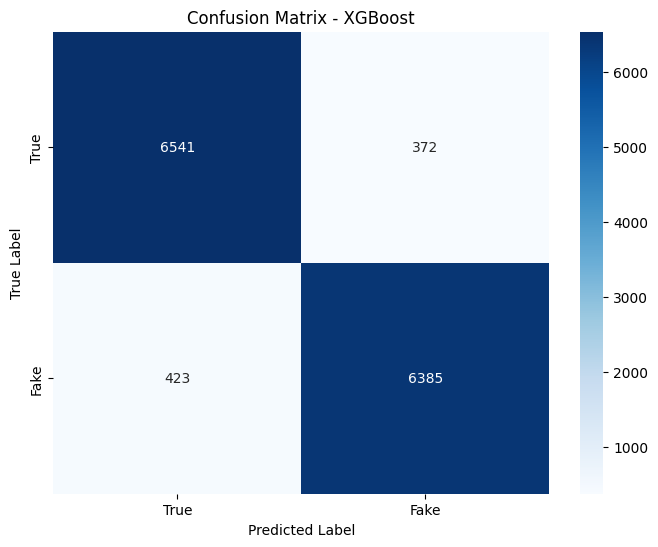


XGBoost Performance Metrics:
Accuracy: 0.9421
Precision (Fake News): 0.9449
Recall (Fake News): 0.9379
F1-score (Fake News): 0.9414
XGBoost model evaluation complete.


In [ ]:
# 3. Model Building (XGBoost)
# XGBoost can work with sparse matrices like X_train_tfidf.
# Initialize the XGBClassifier model
# You can start with default or reasonable parameters.
# For binary classification, use objective='binary:logistic' and eval_metric='logloss' or 'error'.
xgb_model = XGBClassifier(objective='binary:logistic',
                          eval_metric='logloss', # Or 'error', 'auc' etc.
                          use_label_encoder=False, # Suppress warning
                          random_state=42)

# 4. Model Training
print("\nTraining XGBoost model...")
# XGBoost can train directly on sparse TF-IDF matrices
xgb_model.fit(X_train_tfidf, y_train)
print("Training complete.")

# 5. Performance Evaluation
print("\nEvaluating XGBoost model...")
# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluate the model
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("\nConfusion Matrix for XGBoost:")
print(conf_matrix_xgb)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Extract specific metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, pos_label=1)
recall_xgb = recall_score(y_test, y_pred_xgb, pos_label=1)
f1_xgb = f1_score(y_test, y_pred_xgb, pos_label=1)

print("\nXGBoost Performance Metrics:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision (Fake News): {precision_xgb:.4f}")
print(f"Recall (Fake News): {recall_xgb:.4f}")
print(f"F1-score (Fake News): {f1_xgb:.4f}")

print("XGBoost model evaluation complete.")